In [18]:
#imports and functions - run me

import sys
sys.path.append('/dls_sw/apps/scisoftpy/2.7')
sys.path.append('/dls_sw/i16/software/python')
from dlstools.dataloader import *
from dlstools import *
from matplotlib.pyplot import *

from dlstools.tictoc import tictoc
tt = tictoc()

out_folder = '/dls/science/users/spc93/pdc/'
close('all')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_rows',18)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def get_files_and_start_times(path,labelstr):
    
    #debug code -delete
    print path, labelstr
    ###################
    
    files=[]; times=[]
    file_list=os.listdir(path); file_list.sort();
    for file in file_list:
        firstline=pd.read_csv(path+file, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'], nrows=1)
        try:
            times+=[firstline.ToA[0]]
            files+=[file]
        except:
            print "no data: File:", file
    
    df=pd.DataFrame({'files'+labelstr:files, 'ToA'+labelstr:times})
    df['sec'+labelstr]=df['ToA'+labelstr]*2e-9;    df['mins'+labelstr]=df['sec'+labelstr]/60.0;    df['hours'+labelstr]=df['mins'+labelstr]/60.0;
    return df
   
def get_all_file_pairs_old(path_top, path_bot):      
    top_files_times=get_files_and_start_times(path_top,'0')
    bot_files_times=get_files_and_start_times(path_bot,'1')
    all=top_files_times.join(bot_files_times)
    all['ToA_offset']=all.ToA1-all.ToA0
    all['TimeOffsetSec']=all['ToA_offset']*2e-9
    return all


def get_all_file_pairs(path_top, path_bot):      
    top_files_times=get_files_and_start_times(path_top,'0')
    bot_files_times=get_files_and_start_times(path_bot,'1')
    bot_files_times_aligned=bot_files_times.copy()
    for ii in range(len(top_files_times)):
        sec0=top_files_times['sec0'][ii]
        idx=np.abs(bot_files_times.sec1-sec0).idxmin() #find index of closest start time of bot to top
        bot_files_times_aligned.loc[ii] = bot_files_times.loc[idx]
    all=top_files_times.join(bot_files_times_aligned)
    all['ToA_offset']=all.ToA1-all.ToA0
    all['TimeOffsetSec']=all['ToA_offset']*2e-9
    return all


def find_coincidences_old(path_top, path_bot, file_pair_table, file_num_list, coinc_time, coinc_range):
    #coinc_time=10   #count as coincidence if within this value
    #coinc_range=50  #plot range for time histograms
    num_events=0
    num_coinc=0
    for filepairnum in file_num_list:
        print "=== Starting file pair %i" % filepairnum
        t=pd.read_csv(path_top+file_pair_table.files0[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        b=pd.read_csv(path_bot+file_pair_table.files1[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        t['Module']=0; b['Module']=1
        b.I, b.J=255-b.I, 255*2-b.J
        tb=pd.concat([t,b]) #joint modules to make one big detector
        tb.sort_values('ToA',inplace=True)
        tb.ToA=tb.ToA-tb.ToA.min()
        tb['Tdiff']=tb.ToA-tb.ToA.shift(1)
        tb['Mdiff']=tb.Module-tb.Module.shift(1)
        tb['TdiffM']=tb.Tdiff/tb.Mdiff             #ToA difference: +ve if 0 first then 1; -ve if 1 then 0, inf if same module
        coinc_events_range=abs(tb.TdiffM)<=coinc_range #events within coinc_range (for plot)
        tb_coinc_range=tb[coinc_events_range]
        tb_coinc_range.plot(y='TdiffM',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
        coinc_events=abs(tb.TdiffM)<=coinc_time #events within coinc_time (for coincidence data)
        tb_coinc=tb[coinc_events]
        tb_coinc_previous=tb.shift(1)[coinc_events]
        del tb_coinc_previous['Tdiff']; del tb_coinc_previous['Mdiff']; del tb_coinc_previous['TdiffM']; 
        tb_coinc_previous.rename(columns={'I':'I0','J':'J0','ToA':'ToA0','ToT':'ToT0','Module':'Module0'}, inplace=True)
        tb_both=tb_coinc.join(tb_coinc_previous)
        if num_events==0:
            all_coinc=tb_both.copy(deep=True)
        else:
            all_coinc=all_coinc.append(tb_both)
        num_events+=len(t)+len(b)
        num_coinc+=len(tb_both)
    all_coinc.reset_index()
    print "===Total events : %i\tCoincidence : %i\t Percentage of coincidences: %.3f" % (num_events, num_coinc, num_coinc*100./num_events)       
    return all_coinc.astype(int)



def find_coincidences(path_top, path_bot, file_pair_table, file_num_list, coinc_time, coinc_range, remove_adjacent=True, return_all_minus_any_coinc=False, plot_histogram=False):
    #coinc_time=10   #count as coincidence if within this value
    #coinc_range=50  #plot range for time histograms
    #remove_adjacent: remove if there is a coincidence with the previous or next event (attempt at removing charge-sharing)
    #plot_histogram: plot coincidences as histogram (slow!)
    
    num_events=0
    num_coinc=0
    for filepairnum in file_num_list:
        print "=== Starting file pair %i" % filepairnum
        t=pd.read_csv(path_top+file_pair_table.files0[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        b=pd.read_csv(path_bot+file_pair_table.files1[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        t['Module']=0; b['Module']=1
        b.I, b.J=255-b.I, 255*2-b.J
        tb=pd.concat([t,b]) #joint modules to make one big detector
        tb.sort_values('ToA',inplace=True)
        tb.ToA=tb.ToA-tb.ToA.min()
        tb['Tdiff']=tb.ToA-tb.ToA.shift(1)
        tb['Mdiff']=tb.Module-tb.Module.shift(1)
        tb['TdiffM']=tb.Tdiff/tb.Mdiff             #ToA difference: +ve if 0 first then 1; -ve if 1 then 0, inf if same module
        tb['Prev_coinc']=abs(tb.ToA-tb.ToA.shift(2))<=coinc_range
        tb['Next_coinc']=abs(tb.ToA-tb.ToA.shift(-1))<=coinc_range
        coinc_events_range=abs(tb.TdiffM)<=coinc_range #events within coinc_range (for plot)
        tb_coinc_range=tb[coinc_events_range]
        if plot_histogram:
            tb_coinc_range.plot(y='TdiffM',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences

        if not return_all_minus_any_coinc: #normal coincidence calculation
            if remove_adjacent: #coincidences are events between different modules where no coicidence in adjacent events
                #coinc_events=abs(tb.TdiffM)<=coinc_time & ~tb['Prev_coinc'] & ~tb['Next_coinc']
                coinc_events = (abs(tb.TdiffM)<=coinc_time) & (tb['Prev_coinc']==False) & (tb['Next_coinc']==False)
                #tb['BeTrue'] = (abs(tb.TdiffM)<=coinc_time) & (tb['Prev_coinc']==False) & (tb['Next_coinc']==False)
            else: #coincidences are events between different modules 
                coinc_events=abs(tb.TdiffM)<=coinc_time #events within coinc_time (for coincidence data)
        else:#exclude coincidence
            print "======== exlude coinc", return_all_minus_any_coinc ############
            coinc_events = (abs(tb.Tdiff)<=coinc_time)==False
              
        tb_coinc=tb[coinc_events]
        
        #print 'a', len(tb_coinc)
        print path_top+file_pair_table.files0[filepairnum]
        print path_bot+file_pair_table.files1[filepairnum]
        print 'num mod 0 t',len(t[t.Module==0])
        print 'num mod 1 t',len(t[t.Module==1])
        print 'num mod 0 b',len(b[b.Module==0])
        print 'num mod 1 b',len(b[b.Module==1])
        print 'num tb module==0',len(tb[tb.Module==0])
        print 'num tb module==1',len(tb[tb.Module==1])
        print 'len(t)', len(t)
        print 'len(b)', len(b)
        
        
        
        print '=== No. events:', len(tb)
        print '=== No. coinc. events:', len(tb_coinc)
        #print coinc_events ######################### delete
        tb_coinc_previous=tb.shift(1)[coinc_events]
        del tb_coinc_previous['Tdiff']; del tb_coinc_previous['Mdiff']; del tb_coinc_previous['TdiffM']; 
        del tb_coinc_previous['Prev_coinc']; del tb_coinc_previous['Next_coinc']; 
        #del tb_coinc_previous['BeTrue'];
       
        tb_coinc_previous.rename(columns={'I':'I0','J':'J0','ToA':'ToA0','ToT':'ToT0','Module':'Module0'}, inplace=True)

        #print 'b', len(tb_coinc_previous)
        #print tb_coinc
        #print tb_coinc_previous
        
        #print 'b+', len(tb_coinc)
        #tb_both=tb_coinc.join(tb_coinc_previous) ######## bad!
        #tb_both=pd.merge(tb_coinc, tb_coinc_previous) ###### any better?
        tb_both=pd.concat([tb_coinc, tb_coinc_previous], axis=1)
        
        #print "tb_coinc, tb_coinc_previous, tb_both"
        #print tb_coinc
        #print tb_coinc_previous
        #print tb_both     
        #print 'b++', len(tb_both)
        #print num_events
        
        if num_events==0:
            all_coinc=tb_both.copy(deep=True)
        else:
            all_coinc=all_coinc.append(tb_both)
        num_events+=len(t)+len(b)
        num_coinc+=len(tb_both)
        
        #print 'c', len(all_coinc)
        
    all_coinc.reset_index()
    
    #print 'd', len(all_coinc)
    
    print "===Total events : %i\tCoincidence : %i\t Percentage of coincidences: %.3f" % (num_events, num_coinc, num_coinc*100./num_events)       
    #return all_coinc.astype(int) # fails if NaN
    return all_coinc
    #return tb ######## test


def sequential_roi_list(isize, jsize, idivisions, jdivisions):
    iwidth, jwidth=isize/idivisions, jsize/jdivisions 
    roilist=[]
    for ni in range(idivisions):
        for nj in range(jdivisions):  
            roilist+=[[[ni*iwidth,(ni+1)*iwidth-1],[nj*jwidth,(nj+1)*jwidth-1]]]
    return roilist
    
def mk_image1(event_table, isize, jsize):
    mtot=np.zeros([isize, jsize])
    for i in range(len(event_table)):
        mtot[int(event_table.I.iloc[i]), int(event_table.J.iloc[i])]+=1   #event in roi
        #print event_table.I0.iloc[i], event_table.J0.iloc[i]
        mtot[int(event_table.I0.iloc[i]), int(event_table.J0.iloc[i])]+=1 #event in coincidence
        
    return mtot


In [2]:
#settings for 12/12/16 data

min_entries=1000000 #files with fewer entries (photons) not used
datadict={'run1and5':range(2,106)+range(973,1009),
          '50M':range(4,108)+range(485,726),
          '100M':range(280,483)+range(720,972),
          'nobeam':range(112,276)} 
#datadict={'run1and5':range(22,25)} # small test set
#dataset='run1and5'
dataset='50M'

datapath='/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted'

datafolder_top='/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/'
datafolder_bot='/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/'

Sat Dec 15 10:54:20 2018 Elapsed time: 1980.99384499
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/ 0
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/ 1
no data: File: long5_2016-12-12-18-18-18.755716_decoded_Sorted.dat
Sat Dec 15 10:54:44 2018 Elapsed time: 2004.928128
=== Starting file pair 4
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-15-53-24.076502_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-15-56-18.717398_decoded_Sorted.dat
num mod 0 t 1783372
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1857904
num tb module==0 1783372
num tb module==1 1857904
len(t) 1783372
len(b) 1857904
=== No. events: 3641276
=== No. coinc. events: 2211
=== Starting file 

num tb module==0 1776224
num tb module==1 1850140
len(t) 1776224
len(b) 1850140
=== No. events: 3626364
=== No. coinc. events: 2251
=== Starting file pair 18
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-07-24.052536_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-10-18.723443_decoded_Sorted.dat
num mod 0 t 1772157
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1846843
num tb module==0 1772157
num tb module==1 1846843
len(t) 1772157
len(b) 1846843
=== No. events: 3619000
=== No. coinc. events: 2276
=== Starting file pair 19
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-08-24.048536_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_tim

num tb module==0 1785545
num tb module==1 1865186
len(t) 1785545
len(b) 1865186
=== No. events: 3650731
=== No. coinc. events: 2146
=== Starting file pair 33
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-22-24.073655_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-25-18.725921_decoded_Sorted.dat
num mod 0 t 1786498
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1869969
num tb module==0 1786498
num tb module==1 1869969
len(t) 1786498
len(b) 1869969
=== No. events: 3656467
=== No. coinc. events: 2235
=== Starting file pair 34
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-23-24.078655_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_tim

num tb module==0 1780855
num tb module==1 1858836
len(t) 1780855
len(b) 1858836
=== No. events: 3639691
=== No. coinc. events: 2329
=== Starting file pair 48
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-37-24.084491_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-40-18.726398_decoded_Sorted.dat
num mod 0 t 1777855
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1858741
num tb module==0 1777855
num tb module==1 1858741
len(t) 1777855
len(b) 1858741
=== No. events: 3636596
=== No. coinc. events: 2261
=== Starting file pair 49
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-38-24.080491_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_tim

num tb module==0 1797835
num tb module==1 1875591
len(t) 1797835
len(b) 1875591
=== No. events: 3673426
=== No. coinc. events: 2379
=== Starting file pair 63
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-52-24.077651_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-55-18.734876_decoded_Sorted.dat
num mod 0 t 1794057
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1874250
num tb module==0 1794057
num tb module==1 1874250
len(t) 1794057
len(b) 1874250
=== No. events: 3668307
=== No. coinc. events: 2270
=== Starting file pair 64
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-16-53-24.080651_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_tim

num tb module==0 1782634
num tb module==1 1860973
len(t) 1782634
len(b) 1860973
=== No. events: 3643607
=== No. coinc. events: 2236
=== Starting file pair 78
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-07-24.115284_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-10-18.739353_decoded_Sorted.dat
num mod 0 t 1779828
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1857753
num tb module==0 1779828
num tb module==1 1857753
len(t) 1779828
len(b) 1857753
=== No. events: 3637581
=== No. coinc. events: 2168
=== Starting file pair 79
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-08-24.111284_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_tim

num tb module==0 1789703
num tb module==1 1867956
len(t) 1789703
len(b) 1867956
=== No. events: 3657659
=== No. coinc. events: 2273
=== Starting file pair 93
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-22-24.097284_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-25-18.742830_decoded_Sorted.dat
num mod 0 t 1784275
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1865557
num tb module==0 1784275
num tb module==1 1865557
len(t) 1784275
len(b) 1865557
=== No. events: 3649832
=== No. coinc. events: 2208
=== Starting file pair 94
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-23-24.095284_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_tim

num tb module==0 1774370
num tb module==1 1850470
len(t) 1774370
len(b) 1850470
=== No. events: 3624840
=== No. coinc. events: 2213
=== Starting file pair 485
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-23-54-24.098295_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-23-57-18.834102_decoded_Sorted.dat
num mod 0 t 1721908
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1796684
num tb module==0 1721908
num tb module==1 1796684
len(t) 1721908
len(b) 1796684
=== No. events: 3518592
=== No. coinc. events: 2097
=== Starting file pair 486
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-23-55-24.101294_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1713289
num tb module==1 1787327
len(t) 1713289
len(b) 1787327
=== No. events: 3500616
=== No. coinc. events: 2055
=== Starting file pair 500
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-09-24.141290_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-12-18.832579_decoded_Sorted.dat
num mod 0 t 1713826
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1786844
num tb module==0 1713826
num tb module==1 1786844
len(t) 1713826
len(b) 1786844
=== No. events: 3500670
=== No. coinc. events: 2123
=== Starting file pair 501
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-10-24.143290_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1720574
num tb module==1 1795067
len(t) 1720574
len(b) 1795067
=== No. events: 3515641
=== No. coinc. events: 2124
=== Starting file pair 515
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-24-24.184285_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-27-18.839056_decoded_Sorted.dat
num mod 0 t 1716670
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1792928
num tb module==0 1716670
num tb module==1 1792928
len(t) 1716670
len(b) 1792928
=== No. events: 3509598
=== No. coinc. events: 2123
=== Starting file pair 516
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-25-24.188285_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1709043
num tb module==1 1785710
len(t) 1709043
len(b) 1785710
=== No. events: 3494753
=== No. coinc. events: 2022
=== Starting file pair 530
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-39-24.046895_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-42-18.842534_decoded_Sorted.dat
num mod 0 t 1710694
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1786585
num tb module==0 1710694
num tb module==1 1786585
len(t) 1710694
len(b) 1786585
=== No. events: 3497279
=== No. coinc. events: 2020
=== Starting file pair 531
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-40-24.042896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1725443
num tb module==1 1801067
len(t) 1725443
len(b) 1801067
=== No. events: 3526510
=== No. coinc. events: 2102
=== Starting file pair 545
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-54-23.995896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-57-18.842011_decoded_Sorted.dat
num mod 0 t 1722192
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1799479
num tb module==0 1722192
num tb module==1 1799479
len(t) 1722192
len(b) 1799479
=== No. events: 3521671
=== No. coinc. events: 2072
=== Starting file pair 546
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-00-55-23.993896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1707138
num tb module==1 1787988
len(t) 1707138
len(b) 1787988
=== No. events: 3495126
=== No. coinc. events: 2161
=== Starting file pair 560
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-09-23.951896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-12-18.849489_decoded_Sorted.dat
num mod 0 t 1711286
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1783350
num tb module==0 1711286
num tb module==1 1783350
len(t) 1711286
len(b) 1783350
=== No. events: 3494636
=== No. coinc. events: 2069
=== Starting file pair 561
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-10-23.947896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1724755
num tb module==1 1798618
len(t) 1724755
len(b) 1798618
=== No. events: 3523373
=== No. coinc. events: 2106
=== Starting file pair 575
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-24-23.906896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-27-18.850965_decoded_Sorted.dat
num mod 0 t 1719571
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1798626
num tb module==0 1719571
num tb module==1 1798626
len(t) 1719571
len(b) 1798626
=== No. events: 3518197
=== No. coinc. events: 2042
=== Starting file pair 576
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-25-23.904896_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1699785
num tb module==1 1777713
len(t) 1699785
len(b) 1777713
=== No. events: 3477498
=== No. coinc. events: 1932
=== Starting file pair 590
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-39-23.917975_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-42-18.852443_decoded_Sorted.dat
num mod 0 t 1702452
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1779093
num tb module==0 1702452
num tb module==1 1779093
len(t) 1702452
len(b) 1779093
=== No. events: 3481545
=== No. coinc. events: 2055
=== Starting file pair 591
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-40-23.937973_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1715430
num tb module==1 1791266
len(t) 1715430
len(b) 1791266
=== No. events: 3506696
=== No. coinc. events: 2042
=== Starting file pair 605
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-54-24.033154_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-57-18.860920_decoded_Sorted.dat
num mod 0 t 1709410
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1788863
num tb module==0 1709410
num tb module==1 1788863
len(t) 1709410
len(b) 1788863
=== No. events: 3498273
=== No. coinc. events: 2130
=== Starting file pair 606
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-01-55-24.038154_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1700984
num tb module==1 1777496
len(t) 1700984
len(b) 1777496
=== No. events: 3478480
=== No. coinc. events: 2005
=== Starting file pair 620
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-09-24.083149_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-12-18.861397_decoded_Sorted.dat
num mod 0 t 1701788
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1779292
num tb module==0 1701788
num tb module==1 1779292
len(t) 1701788
len(b) 1779292
=== No. events: 3481080
=== No. coinc. events: 2137
=== Starting file pair 621
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-10-24.086149_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1716258
num tb module==1 1791602
len(t) 1716258
len(b) 1791602
=== No. events: 3507860
=== No. coinc. events: 2086
=== Starting file pair 635
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-24-24.124145_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-27-18.866875_decoded_Sorted.dat
num mod 0 t 1711061
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1788845
num tb module==0 1711061
num tb module==1 1788845
len(t) 1711061
len(b) 1788845
=== No. events: 3499906
=== No. coinc. events: 2064
=== Starting file pair 636
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-25-24.127144_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1705736
num tb module==1 1782408
len(t) 1705736
len(b) 1782408
=== No. events: 3488144
=== No. coinc. events: 2084
=== Starting file pair 650
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-39-24.168140_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-42-18.871352_decoded_Sorted.dat
num mod 0 t 1705904
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1779310
num tb module==0 1705904
num tb module==1 1779310
len(t) 1705904
len(b) 1779310
=== No. events: 3485214
=== No. coinc. events: 2080
=== Starting file pair 651
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-40-24.170140_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1715846
num tb module==1 1792961
len(t) 1715846
len(b) 1792961
=== No. events: 3508807
=== No. coinc. events: 2054
=== Starting file pair 665
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-54-24.208135_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-57-18.871829_decoded_Sorted.dat
num mod 0 t 1713869
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1788286
num tb module==0 1713869
num tb module==1 1788286
len(t) 1713869
len(b) 1788286
=== No. events: 3502155
=== No. coinc. events: 2060
=== Starting file pair 666
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-02-55-24.211135_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1702508
num tb module==1 1782064
len(t) 1702508
len(b) 1782064
=== No. events: 3484572
=== No. coinc. events: 1980
=== Starting file pair 680
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-09-24.258131_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-12-18.875307_decoded_Sorted.dat
num mod 0 t 1705529
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1777570
num tb module==0 1705529
num tb module==1 1777570
len(t) 1705529
len(b) 1777570
=== No. events: 3483099
=== No. coinc. events: 2142
=== Starting file pair 681
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-10-24.262131_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1718696
num tb module==1 1798401
len(t) 1718696
len(b) 1798401
=== No. events: 3517097
=== No. coinc. events: 2092
=== Starting file pair 695
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-24-24.304127_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-27-18.880784_decoded_Sorted.dat
num mod 0 t 1714145
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1792526
num tb module==0 1714145
num tb module==1 1792526
len(t) 1714145
len(b) 1792526
=== No. events: 3506671
=== No. coinc. events: 2182
=== Starting file pair 696
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-25-24.307126_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1703925
num tb module==1 1779845
len(t) 1703925
len(b) 1779845
=== No. events: 3483770
=== No. coinc. events: 2065
=== Starting file pair 710
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-39-24.349122_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-42-18.880261_decoded_Sorted.dat
num mod 0 t 1704771
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1779088
num tb module==0 1704771
num tb module==1 1779088
len(t) 1704771
len(b) 1779088
=== No. events: 3483859
=== No. coinc. events: 2036
=== Starting file pair 711
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-40-24.352122_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_t

num tb module==0 1716724
num tb module==1 1793708
len(t) 1716724
len(b) 1793708
=== No. events: 3510432
=== No. coinc. events: 2116
=== Starting file pair 725
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-54-24.350436_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-13-03-57-18.887738_decoded_Sorted.dat
num mod 0 t 1712539
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1790916
num tb module==0 1712539
num tb module==1 1790916
len(t) 1712539
len(b) 1790916
=== No. events: 3503455
=== No. coinc. events: 2069
===Total events : 1223959951	Coincidence : 741716	 Percentage of coincidences: 0.061
Sat Dec 15 11:42:36 2018 Elapsed time: 4876.98281693


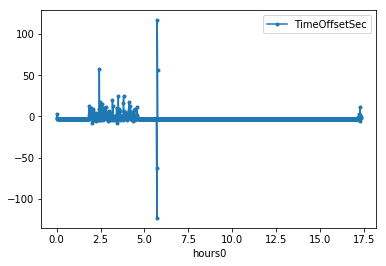

In [13]:
#processing 12/12/16 data

#find coincidences and save to hdf5 - do this once only
# get files corresponding to simultaneous pairs. Write to spreadsheet
print tt
allfiles=get_all_file_pairs(datapath+datafolder_top, datapath+datafolder_bot)
allfiles.plot('hours0','TimeOffsetSec',  marker='.' ); axis('tight')
plt.savefig(out_folder+'plot1.pdf')
writer=pd.ExcelWriter(out_folder+'allfiles.xlsx')
allfiles.to_excel(writer)
writer.save()

print tt
#all_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset][0:8], 10, 50, 
#                            remove_adjacent=True, plot_histogram=False)
all_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset], 10, 50, 
                            remove_adjacent=False, plot_histogram=False)
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
store['all_coinc']=all_coinc
store.close()
print tt


In [5]:
dataset='50M_chargeshare_rem_adj_false'
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back


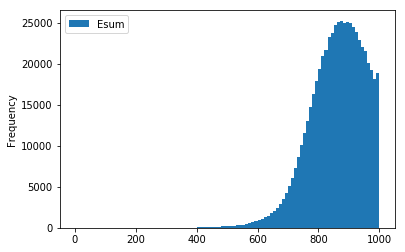

In [6]:
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back
all_coinc['Esum'] = (all_coinc.ToT + all_coinc.ToT0)
all_coinc.plot(y='Esum',kind='hist', bins=range(0,1001,10))

Sat Dec 15 12:47:43 2018 Elapsed time: 7.95759606361
Sat Dec 15 12:47:44 2018 Elapsed time: 8.45240712166


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sat Dec 15 12:47:50 2018 Elapsed time: 15.1897230148


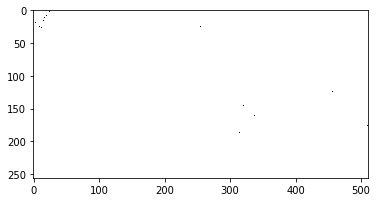

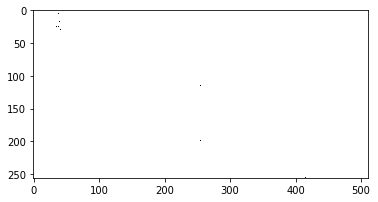

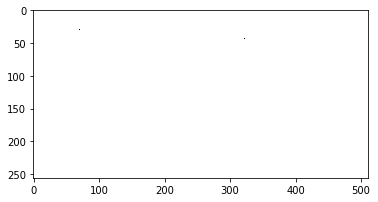

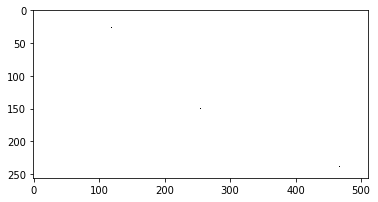

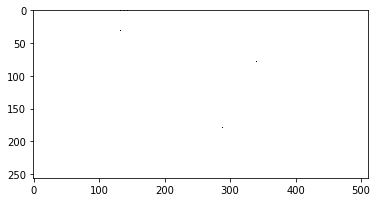

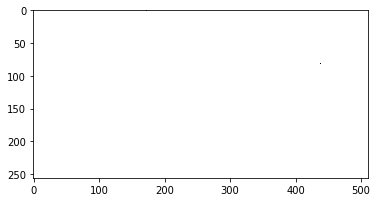

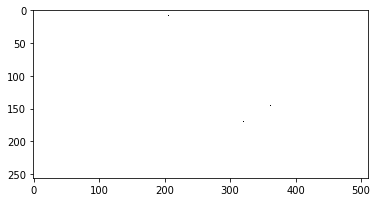

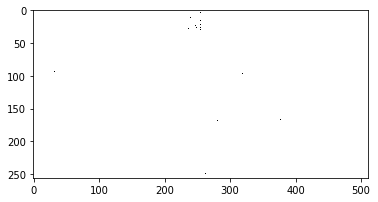

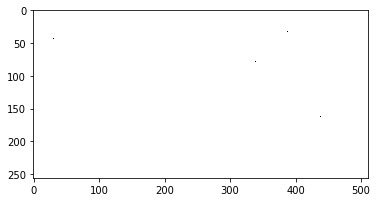

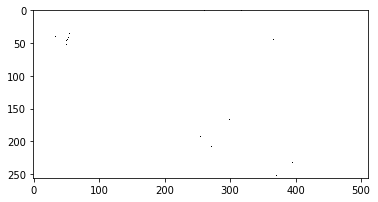

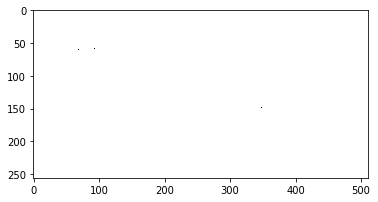

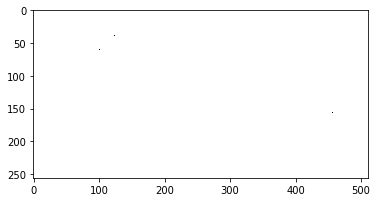

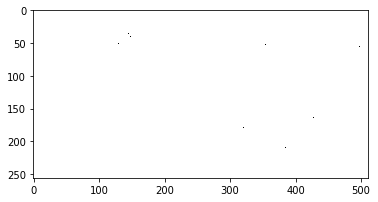

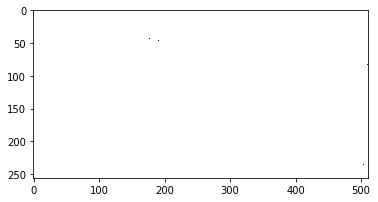

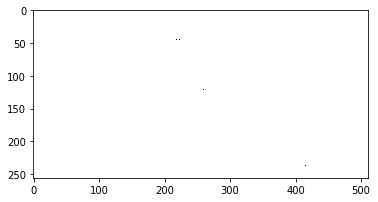

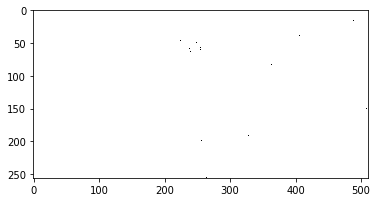

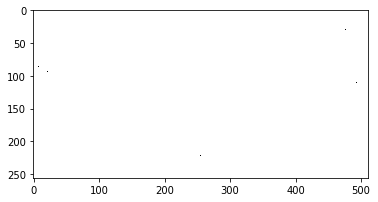

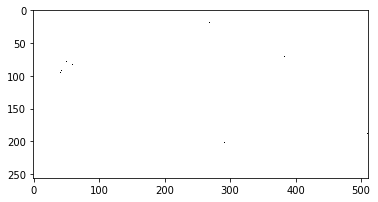

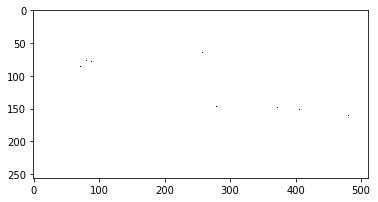

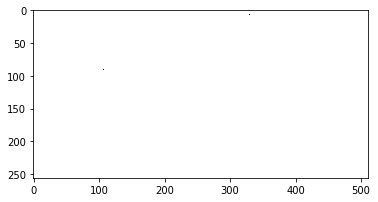

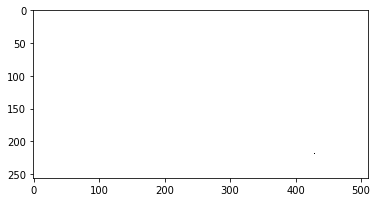

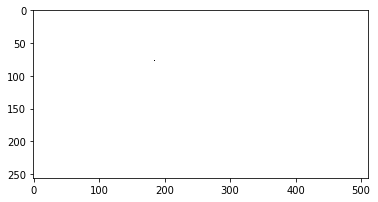

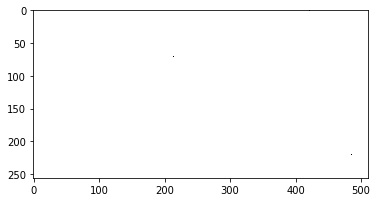

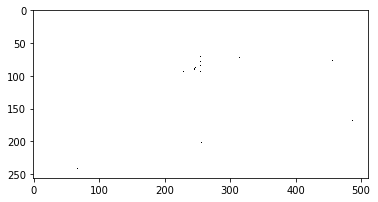

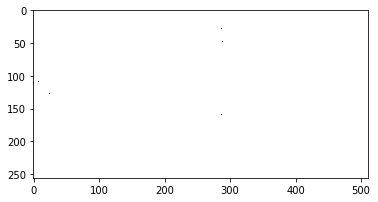

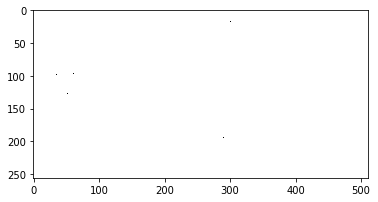

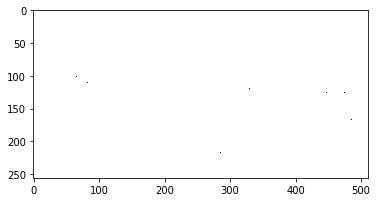

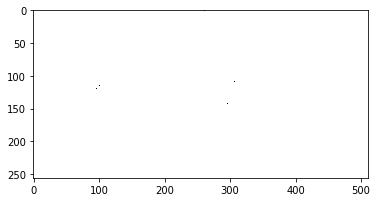

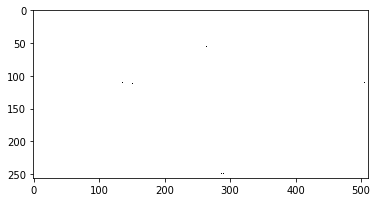

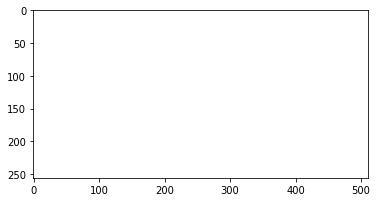

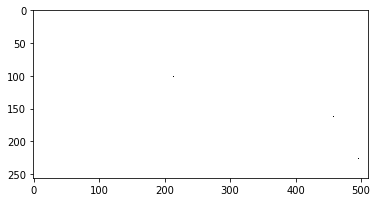

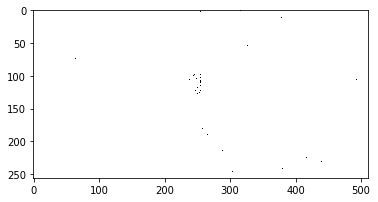

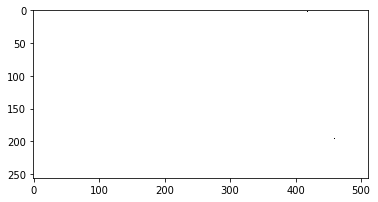

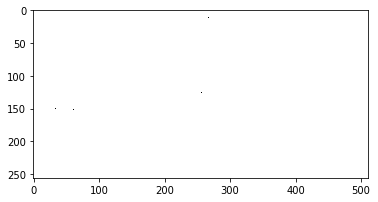

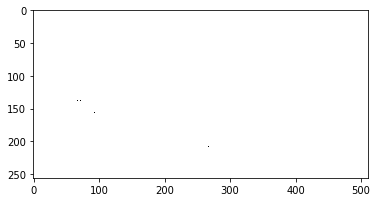

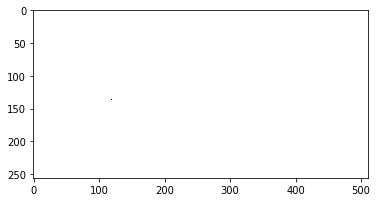

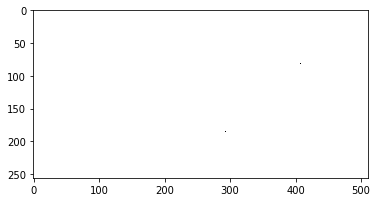

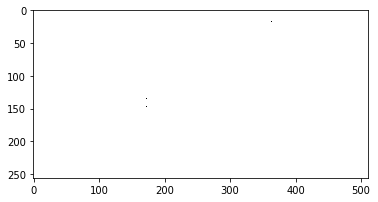

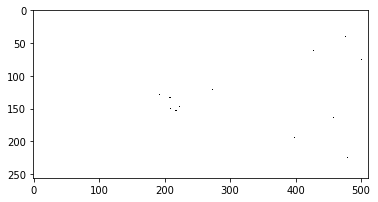

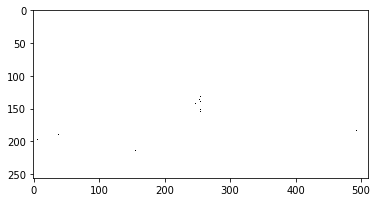

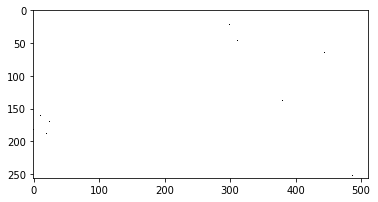

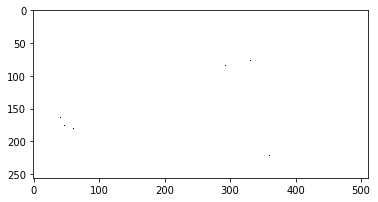

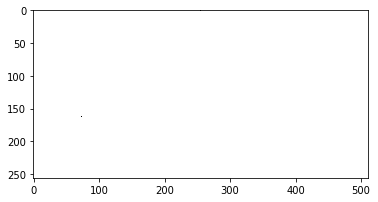

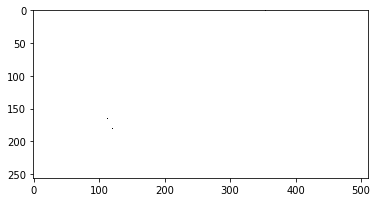

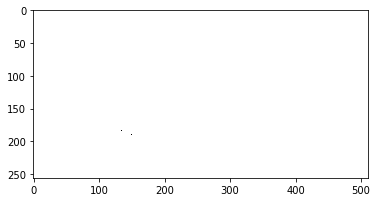

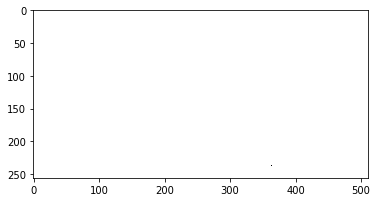

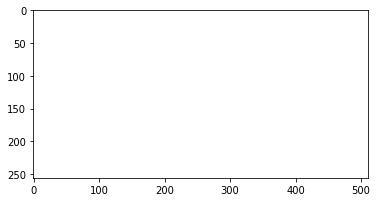

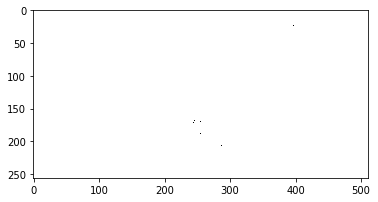

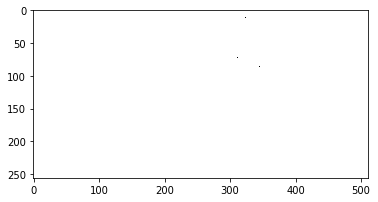

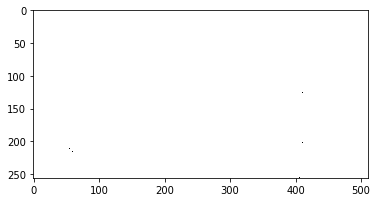

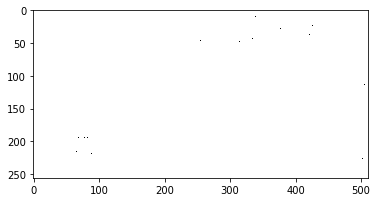

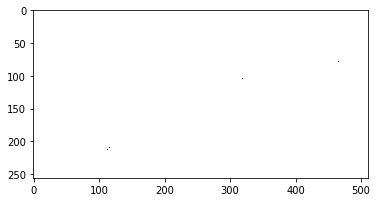

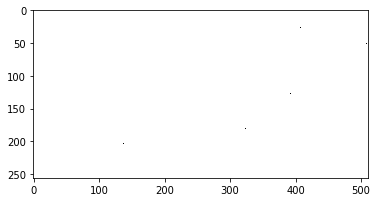

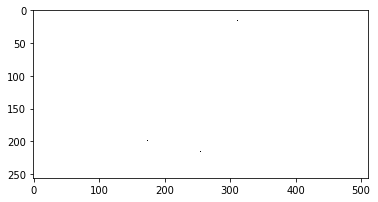

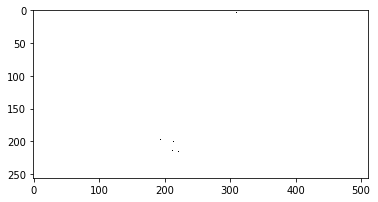

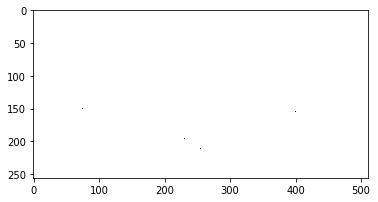

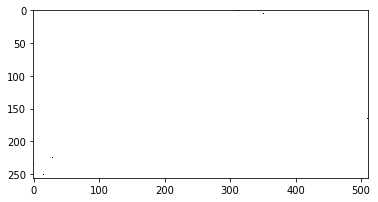

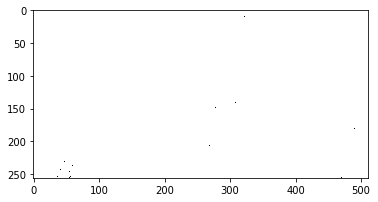

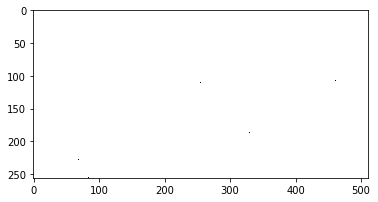

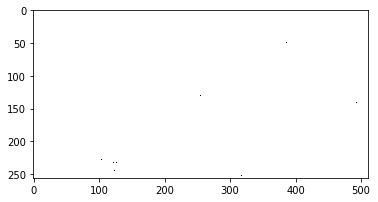

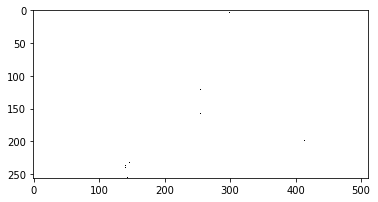

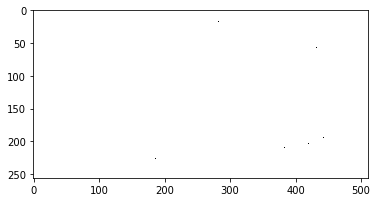

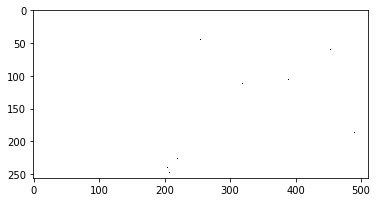

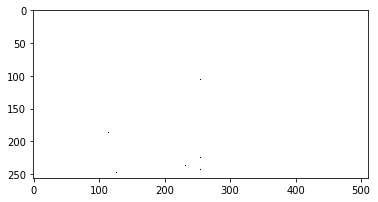

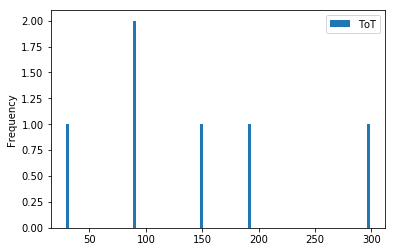

In [19]:
#analyse coincidence data from h5 
#### run first cell first
print tt
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back
isize=max(all_coinc.I+1)
jsize=max(all_coinc.J+1)



#filter
roilist=sequential_roi_list(256,256,8,8)
print tt
for roi in roilist:
    #roi=roilist[36] #single roi in middle
    #time only
    #coinc=all_coinc[(all_coinc.I>=roi[0][0]) & (all_coinc.I<=roi[0][1]) & (all_coinc.J>=roi[1][0]) & (all_coinc.J<=roi[1][1]) ]
    #time and energy
    coinc=all_coinc[(all_coinc.I>=roi[0][0]) & (all_coinc.I<=roi[0][1]) & (all_coinc.J>=roi[1][0]) 
        & (all_coinc.J<=roi[1][1]) &  ((all_coinc.ToT+all_coinc.ToT0)>350)  & ((all_coinc.ToT+all_coinc.ToT0)<475)]
    #create image
    im_coinc=mk_image1(coinc, isize, jsize)
    plt.figure(); plt.imshow(im_coinc, cmap='Greys',vmax=1)
print tt
#coin.plot(y='ToT',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
coinc.plot(y='ToT',kind='hist', bins=100)


In [29]:
256*55e-3

14.08

<IPython.core.display.Javascript object>


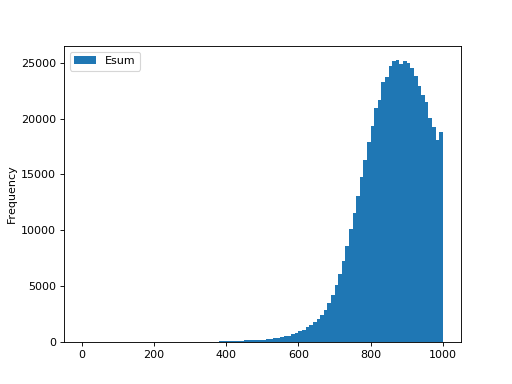

In [26]:
#%matplotlib notebook 
all_coinc['Esum'] = all_coinc.ToT + all_coinc.ToT0
all_coinc.plot(y='Esum',kind='hist', bins=range(0,1001,10))

In [24]:
len(all_coinc)

741716

=== Starting file pair 104
======== exlude coinc True
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-33-24.117650_decoded_Sorted.dat
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/long5_2016-12-12-17-36-18.744580_decoded_Sorted.dat
num mod 0 t 1782827
num mod 1 t 0
num mod 0 b 0
num mod 1 b 1857074
num tb module==0 1782827
num tb module==1 1857074
len(t) 1782827
len(b) 1857074
=== No. events: 3639901
=== No. coinc. events: 3634810
===Total events : 3639901	Coincidence : 3634810	 Percentage of coincidences: 99.860


Text(0.5,1,u'Module 1')

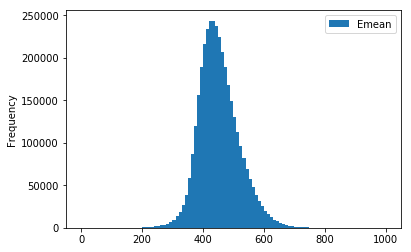

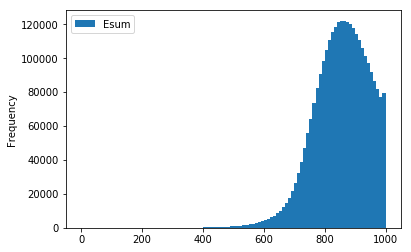

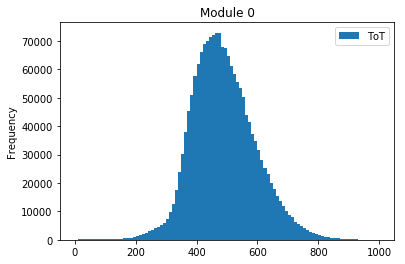

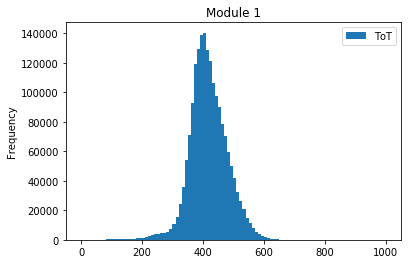

In [12]:
#processs single pair to remove coincidences
not_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset][100:101], 10, 50, 
                            return_all_minus_any_coinc=True, plot_histogram=False)
#not_coinc.plot(y='ToT',kind='hist', bins=range(0,1001,10))
#not_coinc.plot(y='ToT0',kind='hist', bins=range(0,1001,10))
not_coinc['Emean'] = (not_coinc.ToT + not_coinc.ToT0)/2
not_coinc['Esum'] = (not_coinc.ToT + not_coinc.ToT0)
not_coinc.plot(y='Emean',kind='hist', bins=range(0,1001,10))
not_coinc.plot(y='Esum',kind='hist', bins=range(0,1001,10))

not_coinc_module0=not_coinc[not_coinc.Module == 0]
not_coinc_module0.plot(y='ToT',kind='hist', bins=range(0,1001,10)); title('Module 0')

not_coinc_module1=not_coinc[not_coinc.Module == 1]
not_coinc_module1.plot(y='ToT',kind='hist', bins=range(0,1001,10)); title('Module 1')

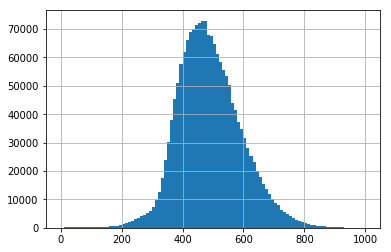

In [10]:
a=not_coinc_module0.ToT.hist(bins=range(0,1001,10))


In [16]:
int(1.0)

1

In [20]:
print len(not_coinc[not_coinc.Module==0])
print len(not_coinc[not_coinc.Module==1])

1781532
2


In [21]:
not_coinc

,I,J,ToA,ToT,Module,Tdiff,Mdiff,TdiffM,Prev_coinc,Next_coinc,I0,J0,ToA0,ToT0,Module0
0,-10,-10,0,0,0,NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN
1,196,386,3692593331,29,1,3.692593e+09,0.0,inf,False,False,265.0,520.0,0.000000e+00,0.0,1.0
2,12,279,6542738606,18,1,2.850145e+09,0.0,inf,False,False,196.0,386.0,3.692593e+09,29.0,1.0
1,171,122,3116695008115,477,0,3.110152e+12,-1.0,-3.110152e+12,False,False,12.0,279.0,6.542739e+09,18.0,1.0
2,67,65,3116695011402,390,0,3.287000e+03,0.0,inf,False,False,171.0,122.0,3.116695e+12,477.0,0.0
3,44,148,3116695011997,518,0,5.950000e+02,0.0,inf,False,False,67.0,65.0,3.116695e+12,390.0,0.0
4,206,84,3116695017011,413,0,5.014000e+03,0.0,inf,False,False,44.0,148.0,3.116695e+12,518.0,0.0
5,160,55,3116695027538,398,0,1.052700e+04,0.0,inf,False,False,206.0,84.0,3.116695e+12,413.0,0.0
6,164,246,3116695040902,538,0,1.336400e+04,0.0,inf,False,False,160.0,55.0,3.116695e+12,398.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [43]:
1744./(len(range(4,108)+range(485,726))*2.1e6)

2.407177363699103e-06

/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted_read_timepix_events_1.3/ 0
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted_read_timepix_events_1.3/ 1
no data: File: long5_2016-12-12-18-18-18.755716_decoded_Sorted.dat


(-0.8662678740213613, 18.215599018106364, -135.16227004840002, 128.8394304724)

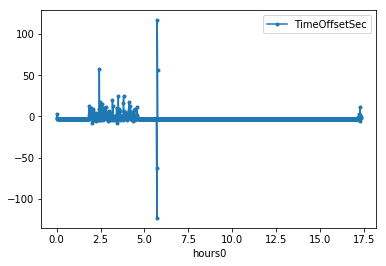

In [4]:
allfiles=get_all_file_pairs(datapath+datafolder_top, datapath+datafolder_bot)
allfiles.plot('hours0','TimeOffsetSec',  marker='.' ); axis('tight')

In [5]:
allfiles

,ToA0,files0,sec0,mins0,hours0,ToA1,files1,sec1,mins1,hours1,ToA_offset,TimeOffsetSec
0,1961481572,long5_2016-12-12-15-49-23.483445_decoded_Sorte...,3.922963,0.065383,0.001090,3692593331,long5_2016-12-12-15-52-18.720671_decoded_Sorte...,7.385187,0.123086,0.002051,1731111759,3.462224
1,27090551147,long5_2016-12-12-15-50-24.060502_decoded_Sorte...,54.181102,0.903018,0.015050,26065274281,long5_2016-12-12-15-53-18.719103_decoded_Sorte...,52.130549,0.868842,0.014481,-1025276866,-2.050554
2,57447371839,long5_2016-12-12-15-51-24.068502_decoded_Sorte...,114.894744,1.914912,0.031915,56705979056,long5_2016-12-12-15-54-18.717535_decoded_Sorte...,113.411958,1.890199,0.031503,-741392783,-1.482786
3,86672979278,long5_2016-12-12-15-52-24.073502_decoded_Sorte...,173.345959,2.889099,0.048152,85068868996,long5_2016-12-12-15-55-18.718966_decoded_Sorte...,170.137738,2.835629,0.047260,-1604110282,-3.208221
4,116672938871,long5_2016-12-12-15-53-24.076502_decoded_Sorte...,233.345878,3.889098,0.064818,115070220898,long5_2016-12-12-15-56-18.717398_decoded_Sorte...,230.140442,3.835674,0.063928,-1602717973,-3.205436
5,146674334539,long5_2016-12-12-15-54-24.082502_decoded_Sorte...,293.348669,4.889144,0.081486,145070332982,long5_2016-12-12-15-57-18.717830_decoded_Sorte...,290.140666,4.835678,0.080595,-1604001557,-3.208003
6,176674258213,long5_2016-12-12-15-55-24.085502_decoded_Sorte...,353.348516,5.889142,0.098152,175069947994,long5_2016-12-12-15-58-18.717262_decoded_Sorte...,350.139896,5.835665,0.097261,-1604310219,-3.208620
7,206673541715,long5_2016-12-12-15-56-24.091502_decoded_Sorte...,413.347083,6.889118,0.114819,205070030234,long5_2016-12-12-15-59-18.717693_decoded_Sorte...,410.140060,6.835668,0.113928,-1603511481,-3.207023
8,236673633583,long5_2016-12-12-15-57-24.086536_decoded_Sorte...,473.347267,7.889121,0.131485,235070208597,long5_2016-12-12-16-00-18.718125_decoded_Sorte...,470.140417,7.835674,0.130595,-1603424986,-3.206850
...,...,...,...,...,...,...,...,...,...,...,...,...
